<a href="https://colab.research.google.com/github/Youssef-Alyy/machine-learning-labs/blob/main/Projects/k_means_clustering_Online_Retail_DS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# K-Means Clustering on an Online Retail Dataset - Youssef Aly

I will be using K-Means clustering for its simplicity, efficiency, and effectivnes in identifying distinct customer segments based on their purchasing behavior. It is also one of the most widely used unsupervised ML algorithms for business insights. According to Scikit learn, K-Means is ideal for general purpose and for data with not too many clusters. In addition, I have decided to go with the RFM analysis based on past work on similar datasets. This analysis enables us to perform customer segmentation and clustering which in turn allows marketers to increase revenue by targeting specific group of existing customers with offers, discounts, etc..
> More details about RFM: https://www.actioniq.com/blog/what-is-rfm-analysis/#:~:text=The%20%E2%80%9CRFM%E2%80%9D%20in%20RFM%20analysis,to%20act%20in%20the%20future.

## Importing the libraries

In [434]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## Importing the dataset

> The Dataset: https://archive.ics.uci.edu/dataset/502/online+retail+ii

In [435]:
dataset = pd.read_excel('online_retail.xlsx')
dataset.head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


## Understanding the Data

In [436]:
print(dataset.shape)
print(dataset.info())
print("NA field count: {}".format(dataset.isna().sum()))

(541910, 8)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541910 entries, 0 to 541909
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   Invoice      541910 non-null  object        
 1   StockCode    541910 non-null  object        
 2   Description  540456 non-null  object        
 3   Quantity     541910 non-null  int64         
 4   InvoiceDate  541910 non-null  datetime64[ns]
 5   Price        541910 non-null  float64       
 6   Customer ID  406830 non-null  float64       
 7   Country      541910 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 33.1+ MB
None
NA field count: Invoice             0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
Price               0
Customer ID    135080
Country             0
dtype: int64


**Observations**:
1. As shown above there are missing values in the Description and Customer ID columns. I will drop the missing Customer ID NA values in the data preprocessing phase to avoid issues and simplify the process during modeling.
2. Some rows contain negative quantities which will also be dropped for simplicity and to avoid confusion during quantification.
3. Group data by customer ID to succesfully perform clustering where each row is unique.
4. To achieve step 3, we will append a new column `amount_spent` of each customer through multiplication of `*Quantity of purchased items * Unit price of said item*` (Monetary).
5. We will also find out the number of transactions a customer has and append it to our new dataset `Frequency`.
6. Finally we will append the `span` duration to identify recent buyers (Recency).
7. Perform IQR to remove outliers.

## Data Preprocessing

### Removing NA values

In [437]:
## Remove CNA values
dataset = dataset.dropna(subset=['Customer ID'])
print(dataset.shape)
print(dataset.info())
print("NA field count: {}".format(dataset.isna().sum()))

(406830, 8)
<class 'pandas.core.frame.DataFrame'>
Index: 406830 entries, 0 to 541909
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   Invoice      406830 non-null  object        
 1   StockCode    406830 non-null  object        
 2   Description  406830 non-null  object        
 3   Quantity     406830 non-null  int64         
 4   InvoiceDate  406830 non-null  datetime64[ns]
 5   Price        406830 non-null  float64       
 6   Customer ID  406830 non-null  float64       
 7   Country      406830 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 27.9+ MB
None
NA field count: Invoice        0
StockCode      0
Description    0
Quantity       0
InvoiceDate    0
Price          0
Customer ID    0
Country        0
dtype: int64


### Removing Negative Quantity values
As shown below, these are the cancelled orders indicated by the `C` (e.g. C536379) as mentioned in the UCI description of the dataset.


In [438]:
##check for the negative quantity values
print(dataset[dataset['Quantity'] < 0])
print(dataset.shape)
##drop them
dataset = dataset[dataset['Quantity'] > 0]
print(dataset.shape)

        Invoice StockCode                       Description  Quantity  \
141     C536379         D                          Discount        -1   
154     C536383    35004C   SET OF 3 COLOURED  FLYING DUCKS        -1   
235     C536391     22556    PLASTERS IN TIN CIRCUS PARADE        -12   
236     C536391     21984  PACK OF 12 PINK PAISLEY TISSUES        -24   
237     C536391     21983  PACK OF 12 BLUE PAISLEY TISSUES        -24   
...         ...       ...                               ...       ...   
540449  C581490     23144   ZINC T-LIGHT HOLDER STARS SMALL       -11   
541541  C581499         M                            Manual        -1   
541715  C581568     21258        VICTORIAN SEWING BOX LARGE        -5   
541716  C581569     84978  HANGING HEART JAR T-LIGHT HOLDER        -1   
541717  C581569     20979     36 PENCILS TUBE RED RETROSPOT        -5   

               InvoiceDate   Price  Customer ID         Country  
141    2010-12-01 09:41:00   27.50      14527.0  United K

### Calculating RFM for each Customer

In [439]:
##grouping by customer id and calculating total amount spent
dataset['Customer ID'] = dataset['Customer ID'].astype(str)
dataset['amount_spent'] = dataset['Quantity'] * dataset['Price']
ds_grouped_am = dataset.groupby('Customer ID')['amount_spent'].sum()
ds_grouped_am = ds_grouped_am.reset_index()
ds_grouped_am.columns = ['Customer ID', 'amount_spent']
ds_grouped_am.head()

,Customer ID,amount_spent
0,12346.0,77183.60
1,12347.0,4310.00
2,12348.0,1797.24
3,12349.0,1757.55
4,12350.0,334.40


In [440]:
## getting total # of transactions for each customer
ds_grouped_f = dataset.groupby('Customer ID')['Invoice'].count()
ds_grouped_f = ds_grouped_f.reset_index()
ds_grouped_f.columns = ['Customer ID', 'Frequency']
ds_grouped_f.head()

,Customer ID,Frequency
0,12346.0,1
1,12347.0,182
2,12348.0,31
3,12349.0,73
4,12350.0,17


In [441]:
ds_grouped = pd.merge(ds_grouped_f,ds_grouped_am, on='Customer ID')
print(ds_grouped.head())
ds_grouped.shape

  Customer ID  Frequency  amount_spent
0     12346.0          1      77183.60
1     12347.0        182       4310.00
2     12348.0         31       1797.24
3     12349.0         73       1757.55
4     12350.0         17        334.40


(4339, 3)

In [442]:
dataset['InvoiceDate'] = pd.to_datetime(dataset['InvoiceDate'], format='%d-%m-%Y %H:%M')
max_date = dataset['InvoiceDate'].max()
dataset['Span'] =  max_date - dataset['InvoiceDate']
ds_grouped_span = dataset.groupby('Customer ID')['Span'].min()
ds_grouped_span = ds_grouped_span.reset_index()
ds_grouped_span.columns = ['Customer ID', 'Span']
ds_grouped_span['Span'] = ds_grouped_span['Span'].dt.days
ds_grouped_span.head()

,Customer ID,Span
0,12346.0,325
1,12347.0,1
2,12348.0,74
3,12349.0,18
4,12350.0,309


In [443]:
ds_grouped = pd.merge(ds_grouped,ds_grouped_span, on='Customer ID')
print(ds_grouped.head())
ds_grouped.shape

  Customer ID  Frequency  amount_spent  Span
0     12346.0          1      77183.60   325
1     12347.0        182       4310.00     1
2     12348.0         31       1797.24    74
3     12349.0         73       1757.55    18
4     12350.0         17        334.40   309


(4339, 4)

### Remove Outliers using IQR

In [444]:
ds_grouped.describe()

,Frequency,amount_spent,Span
count,4339.000000,4339.000000,4339.000000
mean,91.708919,2053.797166,91.518322
std,228.792813,8988.247836,100.009747
min,1.000000,0.000000,0.000000
25%,17.000000,307.245000,17.000000
50%,41.000000,674.450000,50.000000
75%,100.000000,1661.640000,141.000000
max,7847.000000,280206.020000,373.000000


In [445]:
##calculating the first and third quartile for 'frequency' and 'amount_spent'
Q1_freq = ds_grouped.Frequency.quantile(0.05)
Q3_freq = ds_grouped.Frequency.quantile(0.95)
Q1_amount = ds_grouped.amount_spent.quantile(0.05)
Q3_amount = ds_grouped.amount_spent.quantile(0.95)
Q1_span = ds_grouped.Span.quantile(0.05)
Q3_span = ds_grouped.Span.quantile(0.95)

# calculating the IQR
IQR_freq = Q3_freq - Q1_freq
IQR_amount = Q3_amount - Q1_amount
IQR_span = Q3_span - Q1_span

## calculating the upper and lower bounds
lower_bound_freq = Q1_freq - 1.5 * IQR_freq
upper_bound_freq = Q3_freq + 1.5 * IQR_freq
lower_bound_amount = Q1_amount - 1.5 * IQR_amount
upper_bound_amount = Q3_amount + 1.5 * IQR_amount
lower_bound_span = Q1_span - 1.5 * IQR_span
upper_bound_span = Q3_span + 1.5 * IQR_span


#Filter values outside the bounds
ds_grouped_filtered = ds_grouped[((ds_grouped['Frequency'] >= lower_bound_freq) &
                                  (ds_grouped['Frequency'] <= upper_bound_freq)) &
                                  ((ds_grouped['amount_spent'] >= lower_bound_amount) &
                                   (ds_grouped['amount_spent'] <= upper_bound_amount)) &
                                  ((ds_grouped['Span'] >= lower_bound_span) &
                                   (ds_grouped['Span'] <= upper_bound_span))]

print(ds_grouped_filtered.shape)

(4260, 4)


### Scaling the Data

In [446]:
## scaling amount_spent, frequency, and span columns
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
ds_grouped_filtered_scaled = sc.fit_transform(ds_grouped_filtered[['amount_spent','Frequency','Span']])
print(ds_grouped_filtered_scaled)

[[ 1.64220111  1.04641679 -0.91734352]
 [ 0.26043379 -0.45813085 -0.1886798 ]
 [ 0.23860825 -0.0396474  -0.74765471]
 ...
 [-0.62995917 -0.64744479 -0.85745335]
 [ 0.4241061   6.76569062 -0.89738013]
 [ 0.2824518  -0.06953908 -0.50809403]]


## Determining the Optimal number of Clusters

### Silhouette Analysis


In [447]:
#silhouette score
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans

range_n_clusters = [2, 3, 4, 5, 6]
for num_clusters in range_n_clusters:
    # intialise kmeans
    kmeans = KMeans(n_clusters=num_clusters, init='k-means++', max_iter=50, n_init="auto",random_state=42)
    cluster_labels = kmeans.fit_predict(ds_grouped_filtered_scaled)

    # silhouette score
    silhouette_avg = silhouette_score(ds_grouped_filtered_scaled, cluster_labels)
    print("For n_clusters={0}, the avg silhouette score is {1}".format(num_clusters, silhouette_avg))

For n_clusters=2, the avg silhouette score is 0.5411451573317528
For n_clusters=3, the avg silhouette score is 0.5096976064711792
For n_clusters=4, the avg silhouette score is 0.35995179857293036
For n_clusters=5, the avg silhouette score is 0.4133547605247461
For n_clusters=6, the avg silhouette score is 0.41712419577786264


### Elbow Method For reinforcement and verification

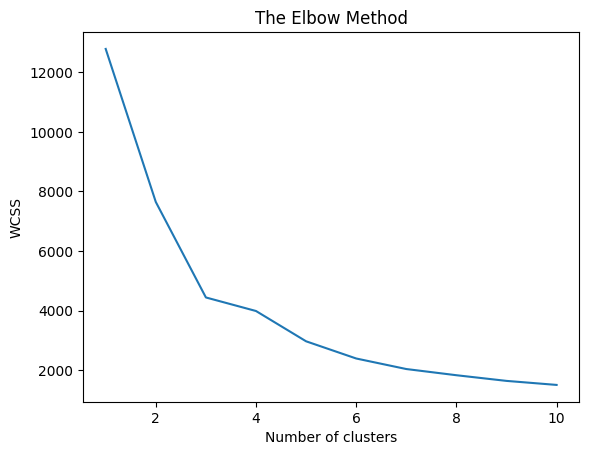

In [448]:
#Elbow method
wcss = []
for i in range(1,11):
    kmeans = KMeans(n_clusters=i, init='k-means++', n_init="auto",random_state=42)
    kmeans.fit(ds_grouped_filtered_scaled)
    wcss.append(kmeans.inertia_)
plt.plot(range(1,11),wcss)
plt.title('The Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

As shown in the Silhhouette Analysis and the Elbow method, it is clear that the optimal # of clusters is 3. Eventhough 2 has a more accurate silhouette average, there is the convention of picking up an odd # for the num of clusters and this is further supported by the elbow method plot above, where the line stops decreasing largely at point 3.

## Building and training the model with 3 Clusters

In [449]:
kmeans = KMeans(n_clusters=3, init='k-means++', max_iter= 50, n_init="auto",random_state=42)
y_kmeans = kmeans.fit_predict(ds_grouped_filtered_scaled)

In [450]:
ds_grouped_filtered = pd.DataFrame(ds_grouped_filtered)
ds_grouped_filtered['cluster'] = y_kmeans
print(ds_grouped_filtered.head())

  Customer ID  Frequency  amount_spent  Span  cluster
1     12347.0        182       4310.00     1        1
2     12348.0         31       1797.24    74        0
3     12349.0         73       1757.55    18        0
4     12350.0         17        334.40   309        2
5     12352.0         85       2506.04    35        0


## Visualising the clusters using a box plot

<Axes: xlabel='cluster', ylabel='Frequency'>

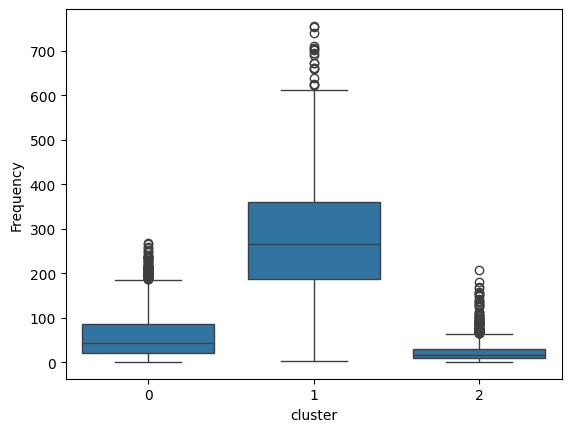

In [451]:
sns.boxplot(x='cluster', y='Frequency', data=ds_grouped_filtered)

<Axes: xlabel='cluster', ylabel='amount_spent'>

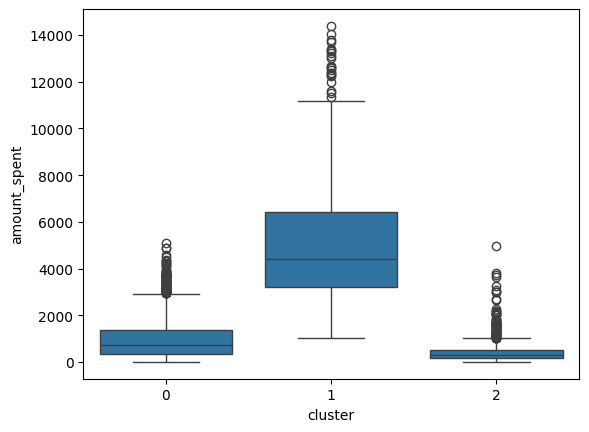

In [452]:
sns.boxplot(x='cluster', y='amount_spent', data=ds_grouped_filtered)

<Axes: xlabel='cluster', ylabel='Span'>

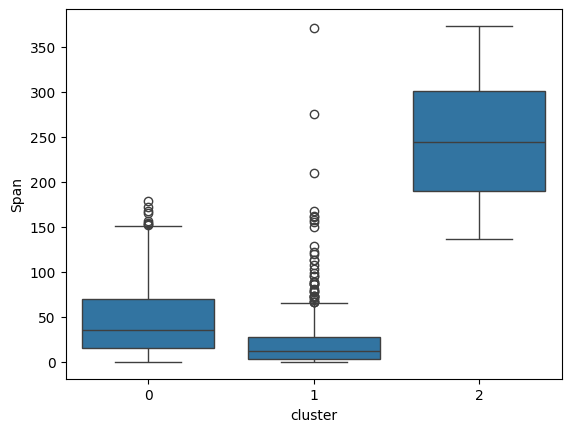

In [453]:
sns.boxplot(x='cluster', y='Span', data=ds_grouped_filtered)

## Inferences and Recommendations

Based on the characteristics of each customer cluster:

**Cluster 1 - Index 0 (Medium Frequency, Moderate Total Amount, Moderate Duration):**

- Actionable Recommendations:
 - Implement a loyalty program to encourage these customers to increase their frequency of purchases.
 - Offer personalized recommendations or product bundles based on their past purchases to increase their average order value.
 - Provide excellent customer service to enhance their overall experience and encourage repeat business.
- **Reasoning for Selection:**
 - Cluster 1 represents customers who are moderately engaged with the brand, making regular but not frequent purchases. By targeting this segment with tailored marketing strategies and incentives, the company can further increase their loyalty and spending.

**Cluster 2 - Index 1 (High Frequency, High Monetary, Excellent Recency):**
- Actionable Recommendations:
 - Offer loyalty rewards or discounts to incentivize even more frequent purchases.
 - Introduce exclusive or limited edition products to capitalize on their high spending habits.
 - Implement personalized recommendations based on their past purchases to encourage repeat business.
- **Reasoning for Selection:**

 - Cluster 2 represents the most valuable customer segment as they contribute significantly to revenue generation with their high frequency of purchases and large spending amounts. Identifying and targeting this segment allows the company to focus its marketing efforts on retaining and further engaging these high-value customers.

**Cluster 3 - Index 2 (Low Frequency, Low Monetary, Bad Recency):**
- Actionable Recommendations:
 - Send targeted marketing campaigns to re-engage these customers and encourage more frequent purchases.
 - Offer incentives such as discounts or promotions to entice them back to make additional purchases.
 - Improve customer experience to address any potential barriers preventing them from making more frequent purchases.
- **Reasoning for Selection:**

 - Cluster 3 represents customers who have low engagement with the brand and minimal spending habits. By identifying this segment, the company can implement strategies to improve customer retention and increase their lifetime value.
